# Overview

- feedback-prize-2021 コンペ。
- abhishek のコードを確認。

Refs
- [two longformers are better than 1 | Kaggle (@abhishek)](https://www.kaggle.com/abhishek/two-longformers-are-better-than-1)

In [1]:
import gc
gc.enable()

import sys
sys.path.append("../input/tez-lib/")

import os

import numpy as np
import pandas as pd
import tez  # tez はシンプルな PyTorch Trainer
import torch
import torch.nn as nn
from joblib import Parallel, delayed
from transformers import AutoConfig, AutoModel, AutoTokenizer

In [2]:
# この ID マップが何なのかは記述がないが、おそらくデータソースとして input に置かれているモデルは、
# これらのラベルをもとに学習されたものと考えられる
target_id_map = {
    "B-Lead": 0,
    "I-Lead": 1,
    "B-Position": 2,
    "I-Position": 3,
    "B-Evidence": 4,
    "I-Evidence": 5,
    "B-Claim": 6,
    "I-Claim": 7,
    "B-Concluding Statement": 8,
    "I-Concluding Statement": 9,
    "B-Counterclaim": 10,
    "I-Counterclaim": 11,
    "B-Rebuttal": 12,
    "I-Rebuttal": 13,
    "O": 14,
    "PAD": -100,
}


id_target_map = {v: k for k, v in target_id_map.items()}

# グローバル変数の宣言
# 2種類の学習済みモデルを使うので、2つのグローバル変数セットを定義
class args1:
    input_path = "../input/feedback-prize-2021/"
    model = "../input/longformerlarge4096/longformer-large-4096/"
    tez_model= "../input/fblongformerlarge1536/"
    output = "."
    batch_size = 8
    max_len = 4096
    
class args2:
    input_path = "../input/feedback-prize-2021/"
    model = "../input/longformerlarge4096/longformer-large-4096/"
    tez_model= "../input/tez-fb-large/"
    output = "."
    batch_size = 8
    max_len = 4096

In [3]:
# データセットクラスの定義
# __getitem__ の return がなぞに ids, mask になっている
class FeedbackDataset:
    def __init__(self, samples, max_len, tokenizer):
        self.samples = samples
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.length = len(samples)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        input_ids = self.samples[idx]["input_ids"]
        # print(input_ids)
        # print(input_labels)

        # add start token id to the input_ids
        input_ids = [self.tokenizer.cls_token_id] + input_ids

        if len(input_ids) > self.max_len - 1:
            input_ids = input_ids[: self.max_len - 1]

        # add end token id to the input_ids
        input_ids = input_ids + [self.tokenizer.sep_token_id]
        attention_mask = [1] * len(input_ids)

        # padding_length = self.max_len - len(input_ids)
        # if padding_length > 0:
        #     if self.tokenizer.padding_side == "right":
        #         input_ids = input_ids + [self.tokenizer.pad_token_id] * padding_length
        #         attention_mask = attention_mask + [0] * padding_length
        #     else:
        #         input_ids = [self.tokenizer.pad_token_id] * padding_length + input_ids
        #         attention_mask = [0] * padding_length + attention_mask

        # return {
        #     "ids": torch.tensor(input_ids, dtype=torch.long),
        #     "mask": torch.tensor(attention_mask, dtype=torch.long),
        # }

        return {
            "ids": input_ids,
            "mask": attention_mask,
        }

In [4]:
# collate は「ページ順に並べる・照合する」という意味。
# もとの実装：
# https://www.kaggle.com/bacicnikola/sequence-bucketing-pytorch-implementation
class Collate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        output = dict()
        output["ids"] = [sample["ids"] for sample in batch]
        output["mask"] = [sample["mask"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["ids"]]
            output["mask"] = [s + (batch_max - len(s)) * [0] for s in output["mask"]]
        else:
            output["ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["ids"]]
            output["mask"] = [(batch_max - len(s)) * [0] + s for s in output["mask"]]

        # convert to tensors
        output["ids"] = torch.tensor(output["ids"], dtype=torch.long)
        output["mask"] = torch.tensor(output["mask"], dtype=torch.long)

        return output

In [5]:
# モデルは以下から：
# https://www.kaggle.com/abhishek/taking-a-long-break-from-kaggle
class FeedbackModel(tez.Model):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model_name = model_name
        self.num_labels = num_labels
        config = AutoConfig.from_pretrained(model_name)

        hidden_dropout_prob: float = 0.1
        layer_norm_eps: float = 1e-7
        config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout_prob": hidden_dropout_prob,
                "layer_norm_eps": layer_norm_eps,
                "add_pooling_layer": False,
            }
        )
        self.transformer = AutoModel.from_config(config)
        self.output = nn.Linear(config.hidden_size, self.num_labels)

    def forward(self, ids, mask):
        transformer_out = self.transformer(ids, mask)
        sequence_output = transformer_out.last_hidden_state
        logits = self.output(sequence_output)
        logits = torch.softmax(logits, dim=-1)
        return logits, 0, {}

In [6]:
def _prepare_test_data_helper(args, tokenizer, ids):
    test_samples = []
    for idx in ids:
        filename = os.path.join(args.input_path, "test", idx + ".txt")
        with open(filename, "r") as f:
            text = f.read()

        encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            return_offsets_mapping=True,
        )
        input_ids = encoded_text["input_ids"]
        offset_mapping = encoded_text["offset_mapping"]

        sample = {
            "id": idx,
            "input_ids": input_ids,
            "text": text,
            "offset_mapping": offset_mapping,
        }

        test_samples.append(sample)
    return test_samples


def prepare_test_data(df, tokenizer, args):
    test_samples = []
    ids = df["id"].unique()
    ids_splits = np.array_split(ids, 4)

    results = Parallel(n_jobs=4, backend="multiprocessing")(
        delayed(_prepare_test_data_helper)(args, tokenizer, idx) for idx in ids_splits
    )
    for result in results:
        test_samples.extend(result)

    return test_samples

In [7]:
# raw_preds に予測スコアの系列
# raw_preds のサイズは (texts, sequences, classes) = (5, 1304, 15)

df = pd.read_csv(os.path.join("../input/feedback-prize-2021/", "sample_submission.csv"))
df_ids = df["id"].unique()

tokenizer = AutoTokenizer.from_pretrained(args1.model)
test_samples = prepare_test_data(df, tokenizer, args1)
collate = Collate(tokenizer=tokenizer)

raw_preds = []
for fold_ in range(10):
    current_idx = 0
    test_dataset = FeedbackDataset(test_samples, args1.max_len, tokenizer)
    
    if fold_ < 5:
        model = FeedbackModel(model_name=args1.model, num_labels=len(target_id_map) - 1)
        model.load(os.path.join(args1.tez_model, f"model_{fold_}.bin"), weights_only=True)
        preds_iter = model.predict(test_dataset, batch_size=args1.batch_size, n_jobs=-1, collate_fn=collate)
    else:
        model = FeedbackModel(model_name=args2.model, num_labels=len(target_id_map) - 1)
        model.load(os.path.join(args2.tez_model, f"model_{fold_-5}.bin"), weights_only=True)
        preds_iter = model.predict(test_dataset, batch_size=args2.batch_size, n_jobs=-1, collate_fn=collate)
        
    current_idx = 0
    
    for preds in preds_iter:
        preds = preds.astype(np.float16)
        preds = preds / 10
        if fold_ == 0:
            raw_preds.append(preds)
        else:
            raw_preds[current_idx] += preds
            current_idx += 1
    torch.cuda.empty_cache()
    gc.collect()

100%|██████████| 1/1 [00:01<00:00,  1.51s/it, stage=test]


In [8]:
print(len(raw_preds))
print(raw_preds[0].shape)
raw_preds[0][0, 0, :]

1
(5, 1304, 15)


array([1.547e-03, 8.860e-04, 1.377e-04, 1.233e-04, 5.764e-05, 9.435e-05,
       7.403e-05, 3.469e-05, 9.894e-06, 3.755e-06, 1.311e-05, 8.106e-06,
       5.007e-06, 1.317e-05, 9.976e-01], dtype=float16)

In [9]:
print(len(test_samples))
print(len(test_samples[0]['input_ids']))
print(len(test_samples[1]['input_ids']))
print(len(test_samples[2]['input_ids']))
print(len(test_samples[3]['input_ids']))
print(len(test_samples[4]['input_ids']))

5
1302
450
756
474
799


In [10]:
# 予測クラスの系列と予測スコアの系列を取得

final_preds = []
final_scores = []

for rp in raw_preds:
    pred_class = np.argmax(rp, axis=2)
    pred_scrs = np.max(rp, axis=2)
    for pred, pred_scr in zip(pred_class, pred_scrs):
        pred = pred.tolist()
        pred_scr = pred_scr.tolist()
        final_preds.append(pred)
        final_scores.append(pred_scr)

for j in range(len(test_samples)):
    tt = [id_target_map[p] for p in final_preds[j][1:]]
    tt_score = final_scores[j][1:]
    test_samples[j]["preds"] = tt
    test_samples[j]["pred_scores"] = tt_score

In [11]:
# 値の確認
print(len(test_samples))
print(test_samples[0].keys())
print(test_samples[0]['preds'][:10])
print(test_samples[0]['pred_scores'][:10])

5
dict_keys(['id', 'input_ids', 'text', 'offset_mapping', 'preds', 'pred_scores'])
['B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead']
[0.9794921875, 0.98046875, 0.98193359375, 0.98291015625, 0.97900390625, 0.9794921875, 0.9814453125, 0.9814453125, 0.97705078125, 0.978515625]


In [12]:
# link_evidence は以下から：
# https://www.kaggle.com/kaggleqrdl/tensorflow-longformer-ner-postprocessing

def jn(pst, start, end):
    return " ".join([str(x) for x in pst[start:end]])


def link_evidence(oof):
    thresh = 1
    idu = oof['id'].unique()
    idc = idu[1]
    eoof = oof[oof['class'] == "Evidence"]
    neoof = oof[oof['class'] != "Evidence"]
    for thresh2 in range(26,27, 1):
        retval = []
        for idv in idu:
            for c in  ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement',
                   'Counterclaim', 'Rebuttal']:
                q = eoof[(eoof['id'] == idv) & (eoof['class'] == c)]
                if len(q) == 0:
                    continue
                pst = []
                for i,r in q.iterrows():
                    pst = pst +[-1] + [int(x) for x in r['predictionstring'].split()]
                start = 1
                end = 1
                for i in range(2,len(pst)):
                    cur = pst[i]
                    end = i
                    #if pst[start] == 205:
                    #   print(cur, pst[start], cur - pst[start])
                    if (cur == -1 and c != 'Evidence') or ((cur == -1) and ((pst[i+1] > pst[end-1] + thresh) or (pst[i+1] - pst[start] > thresh2))):
                        retval.append((idv, c, jn(pst, start, end)))
                        start = i + 1
                v = (idv, c, jn(pst, start, end+1))
                #print(v)
                retval.append(v)
        roof = pd.DataFrame(retval, columns = ['id', 'class', 'predictionstring']) 
        roof = roof.merge(neoof, how='outer')
        return roof
    

In [13]:
proba_thresh = {
    "Lead": 0.7,
    "Position": 0.55,
    "Evidence": 0.65,
    "Claim": 0.55,
    "Concluding Statement": 0.7,
    "Counterclaim": 0.5,
    "Rebuttal": 0.55,
}

min_thresh = {
    "Lead": 9,
    "Position": 5,
    "Evidence": 14,
    "Claim": 3,
    "Concluding Statement": 11,
    "Counterclaim": 6,
    "Rebuttal": 4,
}

submission = []
for sample_idx, sample in enumerate(test_samples):
    preds = sample["preds"]
    offset_mapping = sample["offset_mapping"]
    sample_id = sample["id"]
    sample_text = sample["text"]
    sample_input_ids = sample["input_ids"]
    sample_pred_scores = sample["pred_scores"]
    sample_preds = []

    if len(preds) < len(offset_mapping):
        preds = preds + ["O"] * (len(offset_mapping) - len(preds))
        sample_pred_scores = sample_pred_scores + [0] * (len(offset_mapping) - len(sample_pred_scores))
    
    idx = 0
    phrase_preds = []
    while idx < len(offset_mapping):
        start, _ = offset_mapping[idx]
        if preds[idx] != "O":
            label = preds[idx][2:]
        else:
            label = "O"
        phrase_scores = []
        phrase_scores.append(sample_pred_scores[idx])
        idx += 1
        while idx < len(offset_mapping):
            if label == "O":
                matching_label = "O"
            else:
                matching_label = f"I-{label}"
            if preds[idx] == matching_label:
                _, end = offset_mapping[idx]
                phrase_scores.append(sample_pred_scores[idx])
                idx += 1
            else:
                break
        if "end" in locals():
            phrase = sample_text[start:end]
            phrase_preds.append((phrase, start, end, label, phrase_scores))

    temp_df = []
    for phrase_idx, (phrase, start, end, label, phrase_scores) in enumerate(phrase_preds):
        word_start = len(sample_text[:start].split())
        word_end = word_start + len(sample_text[start:end].split())
        word_end = min(word_end, len(sample_text.split()))
        ps = " ".join([str(x) for x in range(word_start, word_end)])
        if label != "O":
            if sum(phrase_scores) / len(phrase_scores) >= proba_thresh[label]:
                if len(ps.split()) >= min_thresh[label]:
                    temp_df.append((sample_id, label, ps))
    
    temp_df = pd.DataFrame(temp_df, columns=["id", "class", "predictionstring"])
    submission.append(temp_df)

In [14]:
submission = pd.concat(submission).reset_index(drop=True)
submission = link_evidence(submission)
submission.to_csv("submission.csv", index=False)

In [15]:
submission.head()

,id,class,predictionstring
0,18409261F5C2,Evidence,162 163 164 165 166 167 168 169 170 171 172 17...
1,18409261F5C2,Evidence,441 442 443 444 445 446 447 448 449 450 451 45...
2,18409261F5C2,Evidence,739 740 741 742 743 744 745 746 747 748 749 75...
3,D46BCB48440A,Evidence,56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 7...
4,D46BCB48440A,Evidence,150 151 152 153 154 155 156 157 158 159 160 16...


In [16]:
submission['class'].value_counts(normalize=True)

Claim                   0.347826
Evidence                0.304348
Position                0.130435
Lead                    0.108696
Concluding Statement    0.108696
Name: class, dtype: float64

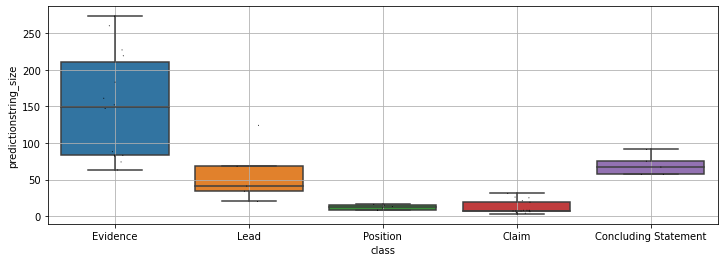

In [17]:
submission['predictionstring_size'] = submission['predictionstring'].apply(lambda x: len(x.split()))
df_melt = submission[['class', 'predictionstring_size']]

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='class', y='predictionstring_size', data=df_melt, showfliers=False, ax=ax)
sns.stripplot(x='class', y='predictionstring_size', data=df_melt, size=1, jitter=True, color='black', ax=ax)
plt.grid()

plt.show()

In [18]:
submission.sort_values(['id', 'predictionstring'])

,id,class,predictionstring,predictionstring_size
28,0FB0700DAF44,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,41
6,0FB0700DAF44,Evidence,123 124 125 126 127 128 129 130 131 132 133 13...,161
30,0FB0700DAF44,Claim,283 284 285 286 287 288 289 290 291 292 293 29...,31
31,0FB0700DAF44,Claim,315 316 317 318 319 320 321 322 323 324 325 32...,26
7,0FB0700DAF44,Evidence,341 342 343 344 345 346 347 348 349 350 351 35...,219
29,0FB0700DAF44,Position,41 42 43 44 45 46 47 48,8
32,0FB0700DAF44,Concluding Statement,560 561 562 563 564 565 566 567 568 569 570 57...,75
14,18409261F5C2,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,124
15,18409261F5C2,Position,125 126 127 128 129 130 131 132 133 134 135 13...,13
16,18409261F5C2,Claim,139 140 141 142 143 144 145,7
